# K-Means Clustering
Cluster splats using K-Means clustering.
This is the offline "oracle" version of the clustering.

In [1]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of clusters.
CLUSTERS = 12

In [3]:
from clustering_exploration.utils.data_handler import load_splats
splats = load_splats(DATA_NAME)

# Cluster Splats

In [5]:
from clustering_exploration.algorithms.k_means import KMeansAlgorithm
clustered_splats = KMeansAlgorithm(splats, CLUSTERS).compute()

Shuffling splats...
Clustering splats...


  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

  0%|          | 0/1051648 [00:00<?, ?it/s]

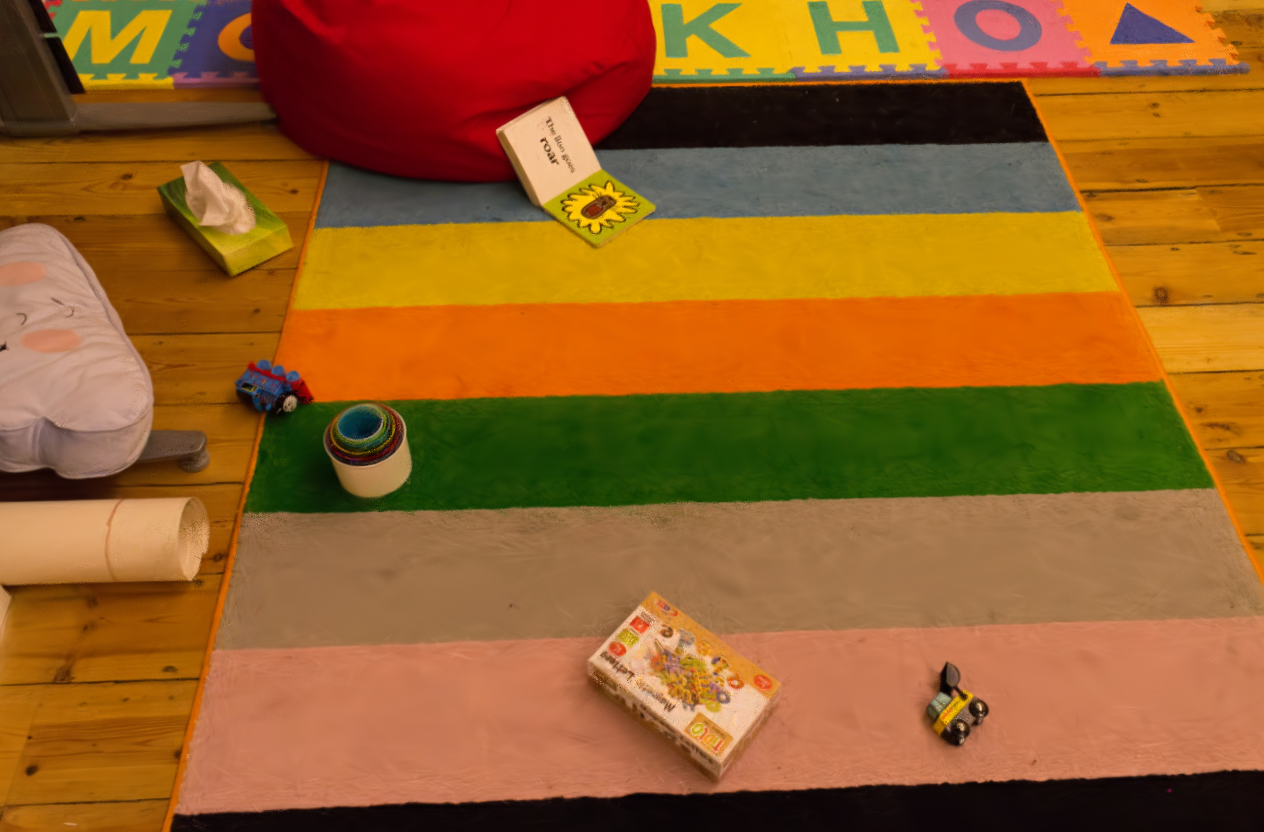

In [7]:
from clustering_exploration.utils.image_handler import compute_image_from_clusters
display(compute_image_from_clusters(clustered_splats, f"k_means_clustering_k_{CLUSTERS}"))